#### 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd
import pyodbc
import pickle
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
os.chdir('T:\\index\\95_곽용하\\운용\\코드\\')
import mf_3 as mf

# DATABASE
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [4]:
# 코스피200, 코스닥150 팩터 수익률 (EW)
sql_return = '''  SELECT BASE_D AS TRD_DT, FactorCode AS FACTOR, BM AS IDX, TILE AS RET_TILE, TILE_RET AS RET_VAL
                    FROM QUANT..SMU_FACTOR_TILE_RET
                    WHERE BM IN ('KS200','KQ150')  '''
rtn_data = pd.read_sql(sql_return, conn_quant)

rtn_data_pvt = rtn_data.pivot_table('RET_VAL',['IDX','TRD_DT','FACTOR'],'RET_TILE',dropna=False)
rtn_data_pvt['RTN_SPRD'] = rtn_data_pvt[4] - rtn_data_pvt[1]
rtn_raw = rtn_data_pvt['RTN_SPRD'].reset_index()
rtn_raw['TRD_DT'] = pd.to_datetime(rtn_raw['TRD_DT'],format="%Y%m%d")
rtn_raw['IDX'] = rtn_raw['IDX'].replace(['KQ150','KS200'],['KSQ150','KSP200'])

C:\Users\11149\AppData\Local\Temp\ipykernel_10864\3127994734.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rtn_data = pd.read_sql(sql_return, conn_quant)


In [25]:
save_path = "T:\\index\\95_곽용하\\연구\\15.트레이딩 전략\\factor_value_momentum\\"
with open(save_path+'factor_rtn_krx.pkl', 'wb') as f:
    pickle.dump(rtn_raw, f)

#### 팩터 조합을 직접 선택하고 싶은 경우

In [5]:
#rtn_raw_pick = rtn_raw[rtn_raw['FACTOR'].isin(['BTM_QW','LOG_MC','GPA','MOM'])]
rtn_raw_pick = rtn_raw.copy()

In [6]:
# KOSPI 200
ksp200_raw = rtn_raw_pick[rtn_raw_pick['IDX']=='KSP200']
ksp200_pivot = ksp200_raw.pivot_table('RTN_SPRD','TRD_DT','FACTOR')

# KOSDAQ 150
ksq150_raw = rtn_raw_pick[rtn_raw_pick['IDX']=='KSQ150']
ksq150_pivot = ksq150_raw.pivot_table('RTN_SPRD','TRD_DT','FACTOR')

### TSFM MODEL

In [7]:
# setting
df = ksp200_pivot.copy() # ksp200_pivot
j = 12
sg_wdw = 36

In [8]:
# 1) Signal (Sigma)
sigma_t = df.rolling(sg_wdw).std()
f_sum = df.rolling(j).sum()
f_sum_over_sigma = f_sum / sigma_t

scaled_sigma = f_sum_over_sigma.copy()
scaled_sigma[scaled_sigma >  2] = 2
scaled_sigma[scaled_sigma < -2] = -2

scaled_sigma = scaled_sigma.fillna(0) #scaled 신호 없으면 중립화(투자 안 함)

In [9]:
# 2) simulation
def normalize_row(row):
    positive_sum = row[row > 0].sum()
    negative_sum = row[row < 0].sum()

    row[row > 0] = row[row > 0] / positive_sum if positive_sum != 0 else 0
    row[row < 0] = row[row < 0] / negative_sum * -1 if negative_sum != 0 else 0
    
    return row

scaled_100_sigma = scaled_sigma.apply(normalize_row, axis=1)
fwd_rtn = df.shift(-1)

predicted_rtn = scaled_100_sigma*fwd_rtn
predicted_rtn_ts = predicted_rtn.sum(axis=1)

<AxesSubplot:xlabel='TRD_DT'>

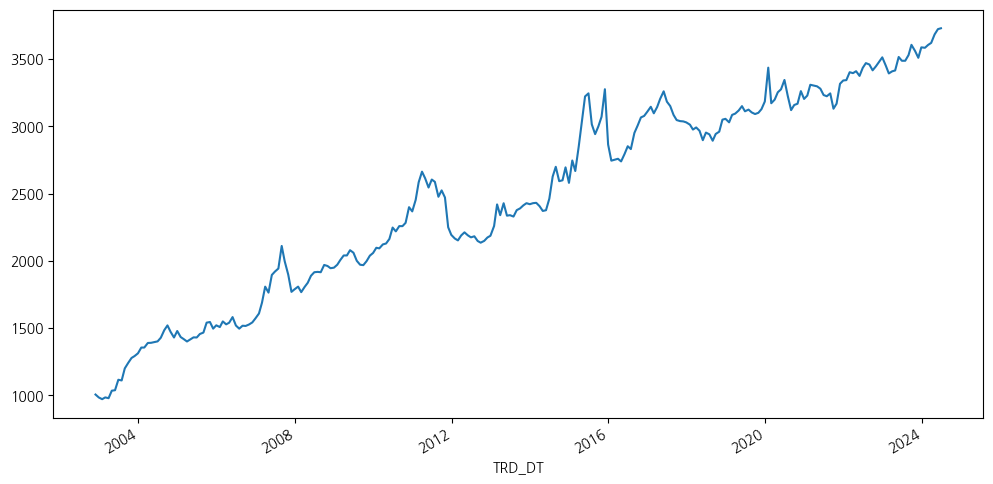

In [13]:
predicted_rtn_ts_1 = predicted_rtn_ts[predicted_rtn_ts != 0]
((1+predicted_rtn_ts_1).cumprod()*1000).plot(figsize=(12,6))

In [19]:
print(mf.annualize_rets(predicted_rtn_ts_1, 12))
print(mf.annualize_vol(predicted_rtn_ts_1, 12))

0.06262510279552358
0.09533669265838103


### alpha test

In [22]:
# sigma 곱한 foward return (scaled)
f_tsfm = fwd_rtn*scaled_sigma

X = fwd_rtn.dropna().values
Y = f_tsfm.dropna().values

regs = LinearRegression()
regs.fit(X,Y)

LinearRegression()